# Figure 4
data is stored in ../../data

# setup and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dms_3d_features.plotting import *

In [2]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "Pyrimidine"
    elif row["both_purine"]:
        return "Purine"
    else:
        return "Mixed"

### load data

In [3]:
DATA_PATH = "../../data/"

In [4]:
df_constructs = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df_constructs_nomod = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_nomod.json"
)
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df["ln_r_data"] = np.log(df["r_data"])
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)

df = df.query("r_data_outlier == False").copy()
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
df_pdb["stack_type"] = df_pdb.apply(assign_stack_type, axis=1)

df_sasa = pd.read_csv(f"{DATA_PATH}/pdb-features/sasa.csv")
df_sasa["m_sequence"] = df_sasa["m_sequence"].apply(lambda x: x.replace("&", "_"))

df_merge = pd.merge(
    df_pdb, df_sasa, on=["m_sequence", "r_nuc", "pdb_r_pos", "pdb_path"]
)
df_merge = df_merge.query("not ln_r_data.isnull()")

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/lg/b_1r07zd7174kpbyfysdr7p0dxd870/T/ipykernel_56398/2638702505.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)


# Plotting 

## Figure 4a

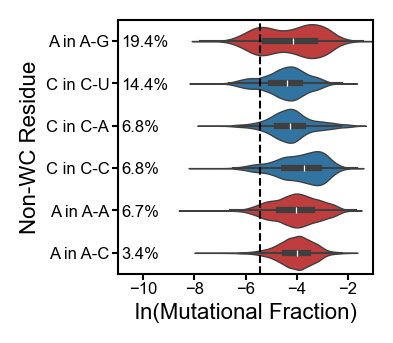

In [5]:
def plot_non_wc_pair_violin(df, ax):
    """
    Plots a violin plot for non-WC pairs (A or C) with likely_pair not empty or AU.
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the relevant columns: r_type, r_nuc, likely_pair, ln_r_data.
    ax : matplotlib.axes.Axes
        The axes on which to plot.
    """
    df_non_wc_pair = df.query(
        "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != ''"
    )
    df_non_wc_pair = df_non_wc_pair.query("likely_pair != 'AU'").copy()
    df_non_wc_pair["cat"] = df_non_wc_pair.apply(
        lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
        axis=1,
    )
    plot_violins_w_percent(
        df_non_wc_pair,
        "ln_r_data",
        "cat",
        gt_lt="less",
        xlim=(-11, -1),
        colors=["tab:red", "tab:blue", "tab:blue", "tab:blue", "tab:red", "tab:red"],
        sorted_by_mean=True,
        ax=ax,
    )
    ax.set_ylabel("Non-WC Residue", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2])
    publication_style_ax(ax)


fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_non_wc_pair_violin(df, ax)

## Figure 4b

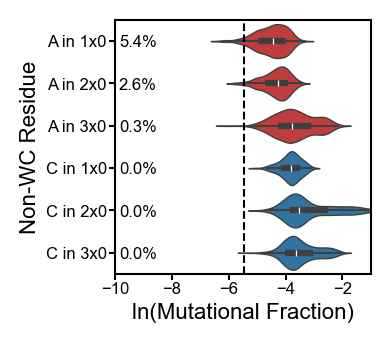

In [6]:
def plot_non_wc_pair_topology_violin(df, ax):
    """
    Plots a violin plot for non-WC pairs with m_token ending in 'x0' (except '5x0').

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the relevant columns: r_type, r_nuc, m_token, ln_r_data.
    ax : matplotlib.axes.Axes
        The axes on which to plot.
    """
    df_sub = df.query("r_type == 'NON-WC' and m_token.str.endswith('x0')")
    # not enough points for 5x0
    df_sub = df_sub.query("m_token != '5x0'").copy()
    df_sub["cat"] = df_sub.apply(
        lambda row: f"{row['r_nuc']} in {row['m_token']}",
        axis=1,
    )
    plot_violins_w_percent(
        df_sub,
        "ln_r_data",
        "cat",
        colors=["tab:red", "tab:red", "tab:red", "tab:blue", "tab:blue", "tab:blue"],
        gt_lt="less",
        xlim=(-10, -1),
        ax=ax,
    )
    ax.set_ylabel("Non-WC Residue", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2])
    publication_style_ax(ax)


# Example usage:
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_non_wc_pair_topology_violin(df, ax)

## Figure 4d

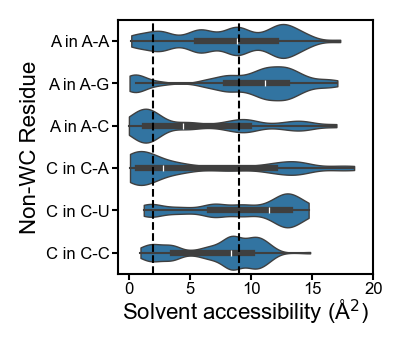

In [7]:
def plot_non_wc_pair_sasa_violin(df, ax):
    """
    Plots a violin plot of solvent accessibility for non-WC pairs (A or C) in 1x1 and matching pairs.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least columns: r_type, r_nuc, m_token, likely_pair, sasa_0_5
    ax : matplotlib.axes.Axes
        Axes object to plot on
    """
    # Get only the cats in 1x1
    df_non_wc_pair_1x1 = df.query(
        "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and m_token == '1x1'"
    ).copy()
    df_non_wc_pair_1x1["cat"] = df_non_wc_pair_1x1.apply(
        lambda row: (
            f"{row['r_nuc']} in {row['likely_pair']}" if row["likely_pair"] else ""
        ),
        axis=1,
    )
    cats = list(df_non_wc_pair_1x1["cat"].unique())

    df_non_wc_pair = df.query(
        "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')"
    ).copy()
    df_non_wc_pair["cat"] = df_non_wc_pair.apply(
        lambda row: (
            f"{row['r_nuc']} in {row['likely_pair']}" if row["likely_pair"] else ""
        ),
        axis=1,
    )
    # Filter df_non_wc_pair to only include rows where 'cat' is in cats
    df_non_wc_pair = df_non_wc_pair[df_non_wc_pair["cat"].isin(cats)]
    df_non_wc_pair["cat"] = df_non_wc_pair.apply(
        lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
        axis=1,
    )

    sns.violinplot(
        data=df_non_wc_pair,
        x="sasa_0_5",
        y="cat",
        density_norm="width",
        linewidth=0.5,
        cut=0,
        ax=ax,
    )
    ax.axvline(2, color="black", linestyle="--", linewidth=0.75)
    ax.axvline(9, color="black", linestyle="--", linewidth=0.75)
    publication_style_ax(ax)
    ax.set_xlabel("Solvent accessibility (Å$^2$)", labelpad=0)
    ax.set_ylabel("Non-WC Residue", labelpad=2)
    ax.set_xticks([0, 5, 10, 15, 20])


# Example usage:
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_non_wc_pair_sasa_violin(df_merge, ax)

<Axes: xlabel='ln(Mutational Fraction)', ylabel='Non-WC Residue'>

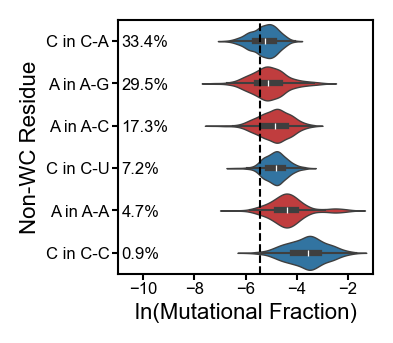

In [8]:
def plot_non_wc_pair_1x1_violin(df, ax):
    """
    Plots violin plots for non-WC pairs (A or C) with likely_pair and m_token == '1x1'.

    Args:
        df (pd.DataFrame): Input dataframe.
        ax (matplotlib.axes.Axes): Axes to plot on.

    Returns:
        matplotlib.axes.Axes: The axes with the plot.
    """
    df_non_wc_pair = df.query(
        "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '1x1'"
    ).copy()
    df_non_wc_pair["cat"] = df_non_wc_pair.apply(
        lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
        axis=1,
    )
    plot_violins_w_percent(
        df_non_wc_pair,
        "ln_r_data",
        "cat",
        gt_lt="less",
        xlim=(-11, -1),
        colors=["tab:blue", "tab:red", "tab:red", "tab:blue", "tab:red", "tab:blue"],
        sorted_by_mean=True,
        ax=ax,
    )
    ax.set_ylabel("Non-WC Residue", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2])
    publication_style_ax(ax)
    return ax


fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_non_wc_pair_1x1_violin(df, ax)

<Axes: xlabel='Solvent accessibility (Å$^2$)', ylabel='Non-WC Residue'>

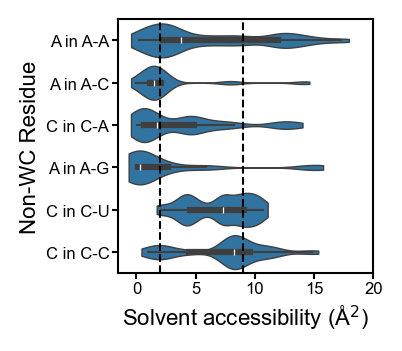

In [9]:
def plot_non_wc_pair_1x1_sasa_violin(df, ax):
    """
    Plots violin plots of solvent accessibility (sasa_0_5) for non-WC pairs (A or C) with likely_pair and m_token == '1x1'.

    Args:
        df (pd.DataFrame): Input dataframe.
        ax (matplotlib.axes.Axes): Axes to plot on.

    Returns:
        matplotlib.axes.Axes: The axes with the plot.
    """
    df_non_wc_pair = df.query(
        "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '1x1'"
    ).copy()
    df_non_wc_pair["cat"] = df_non_wc_pair.apply(
        lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
        axis=1,
    )
    sns.violinplot(
        data=df_non_wc_pair,
        x="sasa_0_5",
        y="cat",
        density_norm="width",
        linewidth=0.5,
        cut=0.5,
        ax=ax,
    )
    ax.axvline(2, color="black", linestyle="--", linewidth=0.75)
    ax.axvline(9, color="black", linestyle="--", linewidth=0.75)

    publication_style_ax(ax)
    ax.set_xlabel("Solvent accessibility (Å$^2$)", labelpad=2)
    ax.set_ylabel("Non-WC Residue", labelpad=2)
    ax.set_xticks([0, 5, 10, 15, 20])
    return ax


fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_non_wc_pair_1x1_sasa_violin(df_merge, ax)

/Users/jyesselman2/Library/CloudStorage/Dropbox/4_papers/2024_dms_quant_framework/dms_3d_features/plotting.py:443: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


<Axes: xlabel='ln(Mutation Fraction)', ylabel='Stacking Residues'>

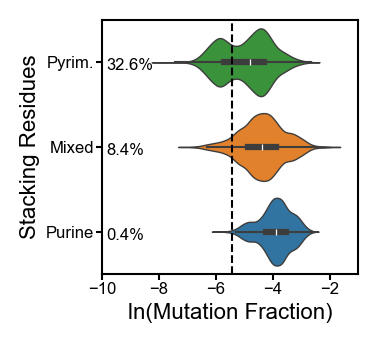

In [10]:
def plot_cu_stack_type_violin(df, ax):
    """
    Plots a violin plot of ln(Mutation Fraction) for C residues in NON-WC CU pairs,
    grouped by stack type.

    Args:
        df (pd.DataFrame): Input dataframe.
        ax (matplotlib.axes.Axes): Axes to plot on.

    Returns:
        matplotlib.axes.Axes: The axes with the plot.
    """
    df_cu = df.query(
        "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CU'"
    ).copy()
    df_cu["stack_type"] = df_cu.apply(assign_stack_type, axis=1)
    ax = plot_violins_w_percent(
        df_cu,
        "ln_r_data",
        "stack_type",
        color=None,
        gt_lt="less",
        xlim=(-10, -1),
        sorted_by_mean=True,
        ax=ax,
    )
    ax.set_ylabel("Stacking Residues", labelpad=2)
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_yticks([0, 1, 2], labels=["Pyrim.", "Mixed", "Purine"])
    ax.set_xticks([-10, -8, -6, -4, -2])
    publication_style_ax(ax)
    return ax


fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_cu_stack_type_violin(df, ax)

/Users/jyesselman2/Library/CloudStorage/Dropbox/4_papers/2024_dms_quant_framework/dms_3d_features/plotting.py:443: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


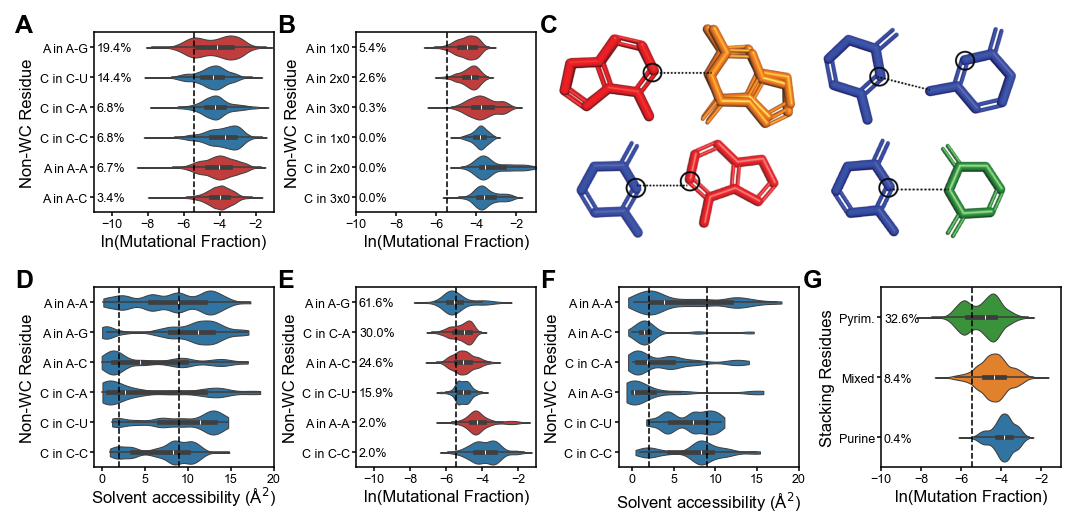

In [ ]:
fig_size = (7, 6)
layout = (2, 4)
subplot_size = (1.2, 1.2)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.55,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.50, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
coords_list = merge_neighboring_coords(coords_list, [2, 3])

fig = plt.figure(figsize=fig_size, dpi=150)
fig.patches = []

ax1 = fig.add_axes(coords_list[0])
plot_non_wc_pair_violin(df, ax1)

ax2 = fig.add_axes(coords_list[1])
plot_non_wc_pair_topology_violin(df, ax2)

adjusted_coords = adjust_subplot_size(coords_list[2], 1.20)
adjusted_coords = shift_subplot_center(adjusted_coords, dx=-0.05, dy=-0.010)
ax3 = fig.add_axes(adjusted_coords)
load_and_fit_image_to_subplot("../../figures/figure_4c.png", ax3)

ax4 = fig.add_axes(coords_list[3])
plot_non_wc_pair_sasa_violin(df_merge, ax4)

ax5 = fig.add_axes(coords_list[4])
plot_non_wc_pair_1x1_violin(df_merge, ax5)

ax6 = fig.add_axes(coords_list[5])
plot_non_wc_pair_1x1_sasa_violin(df_merge, ax6)

ax7 = fig.add_axes(coords_list[6])
plot_cu_stack_type_violin(df, ax7)

add_subplot_labels(fig, coords_list, left_offset=0.075)

fig.savefig("../../figures/figure_4.png", dpi=600, bbox_inches="tight")